In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $\sigma$ and $D$ for underlying $p_{\rm eq}$

In [3]:
D = 500; # Diffusion coefficient
sigma_kref = 8.

kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

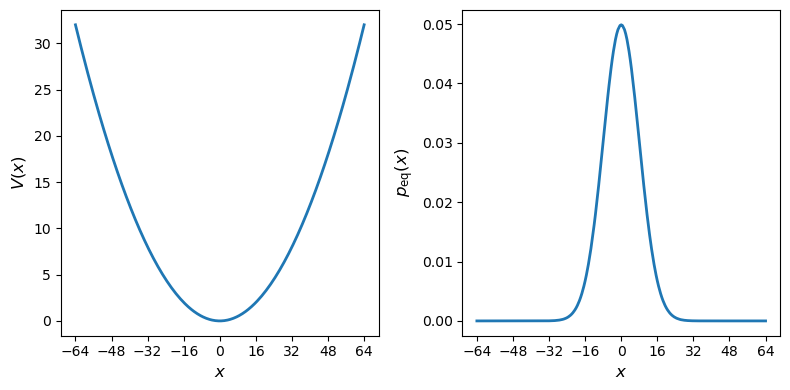

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 3: Get eigenvalues and eigenvectors

In [5]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D, Nv);

In [9]:
1 / Lambdas[2] ### approximate relaxation time

0.12800000200505254

### Part 4: Set $\sigma$ and $D$ for photon operator(Dirac-Delta) $p_{\rm Dirac}$

In [125]:
sigma_dirac = 2.5
k_dirac = get_k_by_sigma(sigma_dirac)
V_dirac = harmonic_well_k_mean(xref, k_dirac, xavg)
rho_dirac = get_rhoeq(V_dirac, w0)
p_dirac = rho_dirac .* rho_dirac;

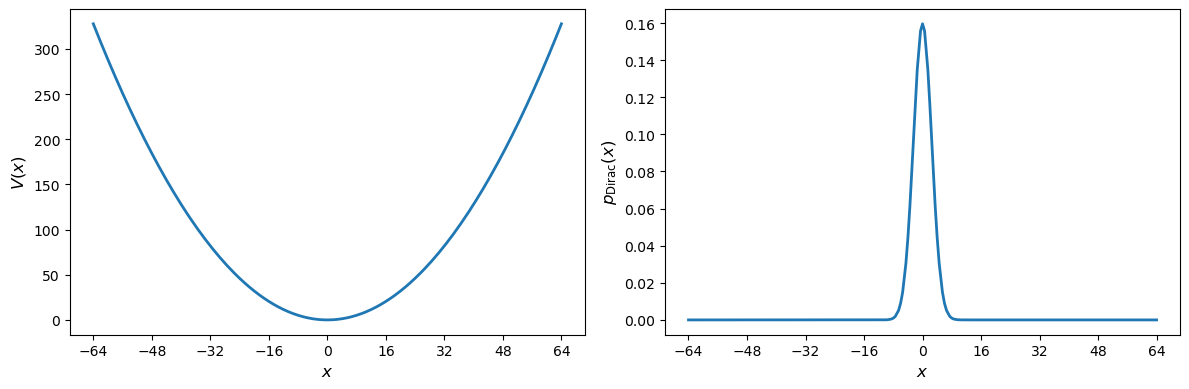

In [126]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, V_dirac, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p_dirac, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm Dirac}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 5: Get $a_i = \left<\alpha_{t0} | \psi_i \right>$, where $i=1,\cdots,N_v$ and get $p_{appr}$

In [127]:
a_array = FEM.get_coefficients_by_proj(w0, rho_dirac, Qx, Nv);

### Part 6: $\rho_{appr}(x) = a_1 \psi_1(x)+ a_2 \psi_2(x)+\cdots+ a_n \psi_n(x) $

In [128]:
rho0_appr = zeros(N)
for idx_eigv in 1:Nv
    rho0_appr = rho0_appr .+ (a_array[idx_eigv] .* Qx[:, idx_eigv])
end

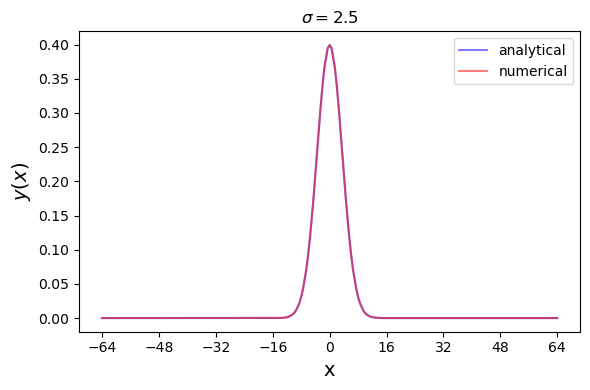

In [129]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(xref, rho_dirac, color="blue", alpha=0.5, label="analytical")
ax.plot(xref, rho0_appr, color="red", alpha=0.5, label="numerical")
ax.legend()
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("\$ y(x) \$", fontsize=14)
ax.set_xticks(-64:16:64)
title = @sprintf "\$\\sigma=%1.1f\$" sigma_dirac
ax.set_title(title)

plt.tight_layout()
plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/sigma_5.svg")
plt.show()

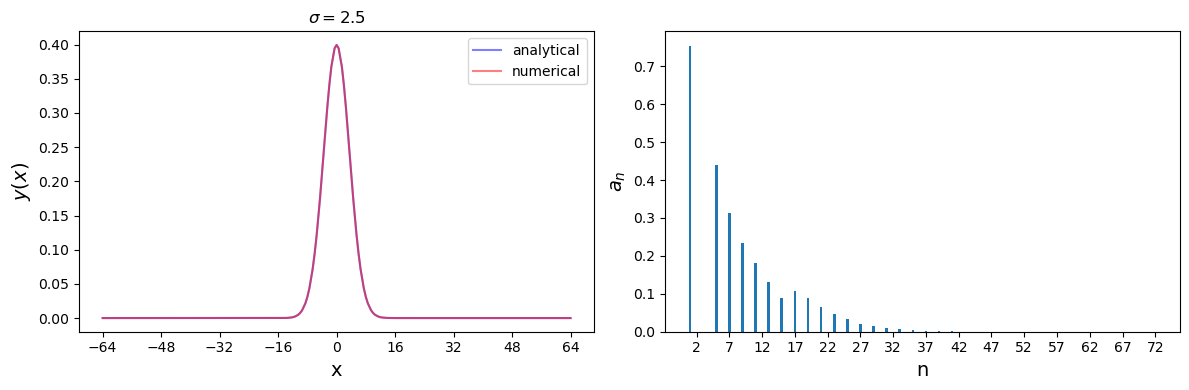

In [98]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_dirac, color="blue", alpha=0.5, label="analytical")
ax.plot(xref, rho0_appr, color="red", alpha=0.5, label="numerical")
ax.legend()
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("\$ y(x) \$", fontsize=14)
ax.set_xticks(-64:16:64)
title = @sprintf "\$\\sigma=%1.1f\$" sigma_dirac
ax.set_title(title)

w = 0.4
xlist = 1:72
xticks = 2:5:72
ax = axes[2]
ax.bar(xlist, abs.(a_array), w)
ax.set_xticks(xticks)
ax.set_ylabel("\$ a_n \$", fontsize=14)
ax.set_xlabel("n", fontsize=14)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/sigma_5.svg")
plt.show()